In [1]:
from ast import literal_eval

import numpy as np
import corner

import matplotlib.pyplot as plt
pltparams = {"axes.grid": False,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
        "axes.labelsize": 24,
        "legend.fontsize": 24,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(pltparams)

default_corner_kwargs = dict(bins=40, 
                        smooth=True, 
                        label_kwargs=dict(fontsize=16),
                        title_kwargs=dict(fontsize=16), 
                        quantiles=[],
                        levels=[0.68, 0.95],
                        plot_density=False, 
                        plot_datapoints=False, 
                        fill_contours=False,
                        max_n_ticks=4, 
                        min_n_ticks=3,
                        save=False,
                        truth_color="darkorange")

import pandas as pd
from fiesta.plot import latex_labels
from fiesta.plot import LightcurvePlotter

# Compare posteriors with pbag & afgpy

Load the data

In [2]:
posterior_pbag = pd.DataFrame(dict(np.load("./pbag/posterior.npz")))
posterior_afgpy = pd.DataFrame(dict(np.load("./afgpy/posterior.npz")))

Make corner plot

In [3]:
var_names = ["inclination_EM", "log10_E0", "thetaCore", "p", "log10_n0"]

labels = [latex_labels[p] for p in var_names]

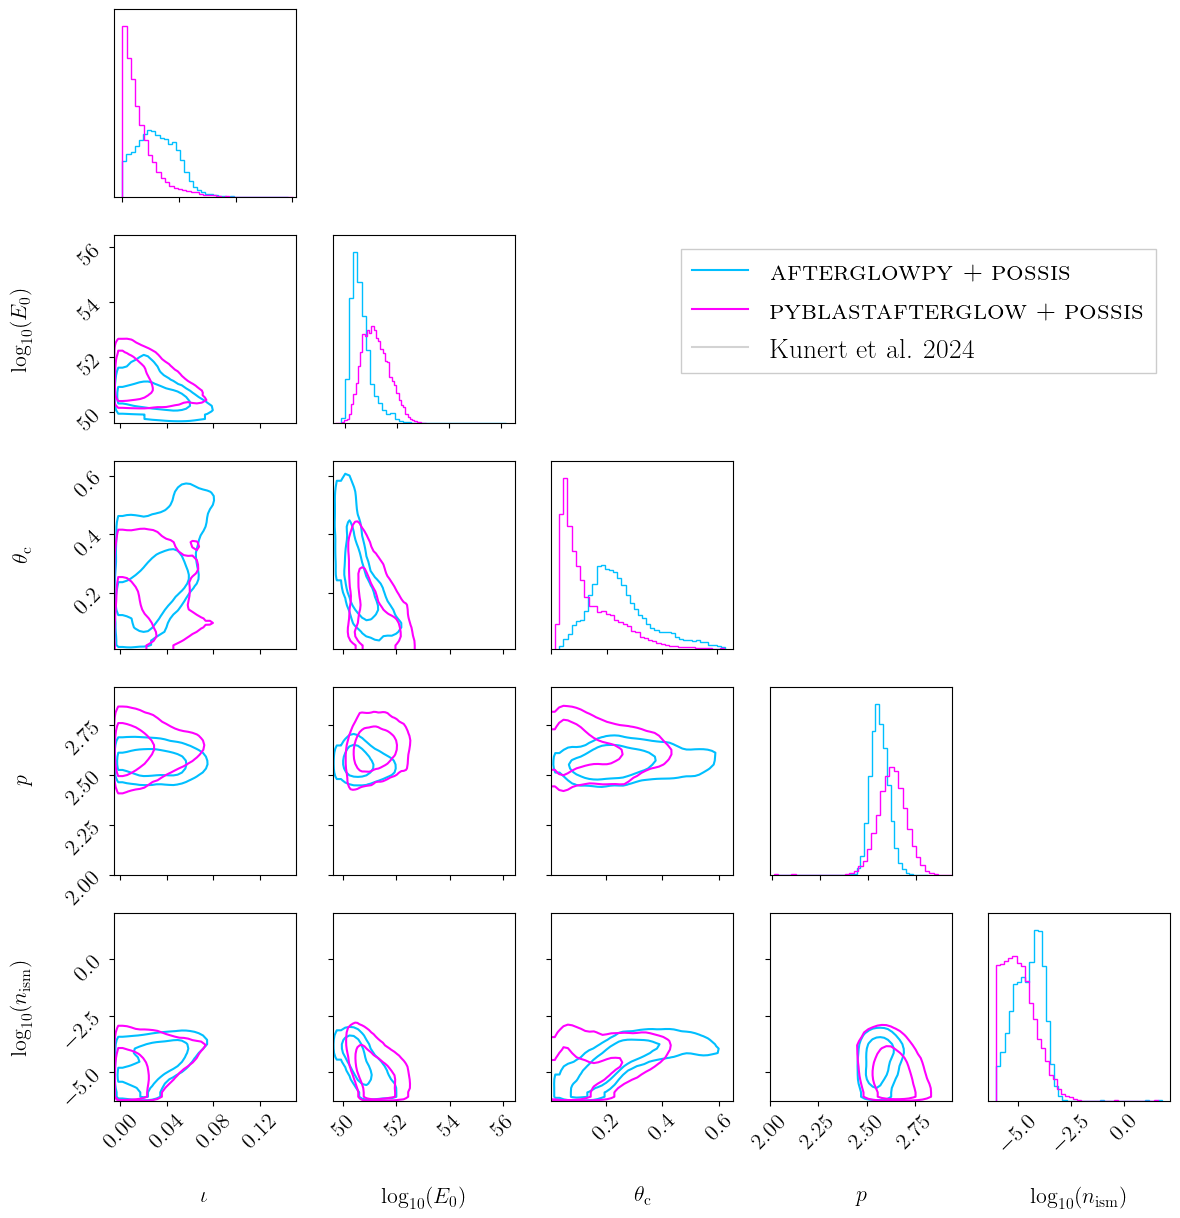

In [4]:
fig, ax = plt.subplots(len(var_names), len(var_names), figsize = (12, 12))


corner.corner(posterior_afgpy[var_names],
              fig=fig,
              color = "deepskyblue",
              labelpad = 0.15,
              labels=labels,
              **default_corner_kwargs,
              hist_kwargs=dict(density=True))

corner.corner(posterior_pbag[var_names],
              fig=fig,
              color="magenta",
              labelpad=0.15,
              labels=labels,
              **default_corner_kwargs,
              hist_kwargs=dict(density=True))

handles = []
for c in ["deepskyblue", "magenta", "lightgrey"]:
    handle = plt.plot([],[], color=c)[0]
    handles.append(handle)

ax[1, 4].legend(handles=handles, labels=["\\textsc{afterglowpy} + \\textsc{possis}", "\\textsc{pyblastafterglow} + \\textsc{possis}", "Kunert et al. 2024"], fontsize=20, fancybox=False, framealpha=1)
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.96, top=0.99, hspace=0.2, wspace=0.2)


fig.savefig("posterior_GRB211211A.pdf", dpi=250)

# Lightcurves

In [5]:
from fiesta.inference.lightcurve_model import AfterglowFlux, BullaFlux, CombinedSurrogate
from fiesta.utils import load_event_data
from fiesta.inference.likelihood import EMLikelihood

data = load_event_data("../../data/GRB211211A.dat")
trigger_time = 59559.54791666667

model_afgpy = AfterglowFlux(name="afgpy_gaussian_CVAE",
                      filters = data.keys())

model_pbag = AfterglowFlux(name="pbag_gaussian_CVAE",
                           filters=data.keys())

11:03 fiesta INFO    : Loading surrogate afgpy_gaussian_CVAE. This surrogate should only be used in the following parameter ranges:
11:03 fiesta INFO    : 	 inclination_EM: (0, 1.5707963267948966)
11:03 fiesta INFO    : 	 log10_E0: (47, 57)
11:03 fiesta INFO    : 	 thetaCore: (0.01, 0.6283185307179586)
11:03 fiesta INFO    : 	 alphaWing: (0.2, 3.5)
11:03 fiesta INFO    : 	 log10_n0: (-6, 2)
11:03 fiesta INFO    : 	 p: (2.01, 3)
11:03 fiesta INFO    : 	 log10_epsilon_e: (-4, 0)
11:03 fiesta INFO    : 	 log10_epsilon_B: (-8, 0)
11:03 fiesta INFO    : Surrogate afgpy_gaussian_CVAE is loading with source-frame time range [1.e-04 2.e+03] days.
11:03 fiesta INFO    : Surrogate afgpy_gaussian_CVAE is loading with the following filters: ['2massh', '2massj', '2massks', 'X-ray-1keV', 'bessellb', 'besselli', 'bessellr', 'bessellux', 'bessellv', 'ps1::g', 'ps1::i', 'ps1::r', 'ps1::z', 'radio-6GHz', 'uvot::b', 'uvot::u', 'uvot::uvm2', 'uvot::uvw1', 'uvot::uvw2', 'uvot::v', 'uvot::white'].
11:03 fie

In [6]:
likelihood_afgpy = EMLikelihood(model_afgpy,
                          data,
                          tmin=0.2,
                          tmax=150.,
                          trigger_time=trigger_time,
                          detection_limit = None,
                          fixed_params={"luminosity_distance": 358.47968, "redshift": 0.0763})

lc_plotter_afgpy = LightcurvePlotter(posterior_afgpy,
                                     likelihood_afgpy,
                                     free_syserr=True)


likelihood_pbag = EMLikelihood(model_pbag,
                          data,
                          tmin=0.2,
                          tmax=150.,
                          trigger_time=trigger_time,
                          detection_limit = None,
                          fixed_params={"luminosity_distance": 358.47968, "redshift": 0.0763})

lc_plotter_pbag = LightcurvePlotter(posterior_pbag,
                                     likelihood_pbag,
                                     free_syserr=True)

11:03 fiesta INFO    : Loading and preprocessing observations in likelihood . . .
11:03 fiesta INFO    : No detection limit is given. Putting it to infinity.
11:03 fiesta INFO    : Loading and preprocessing observations in likelihood . . . DONE
11:03 fiesta INFO    : Loading and preprocessing observations in likelihood . . .
11:03 fiesta INFO    : No detection limit is given. Putting it to infinity.
11:03 fiesta INFO    : Loading and preprocessing observations in likelihood . . . DONE


/tmp/ipykernel_16896/2039179750.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


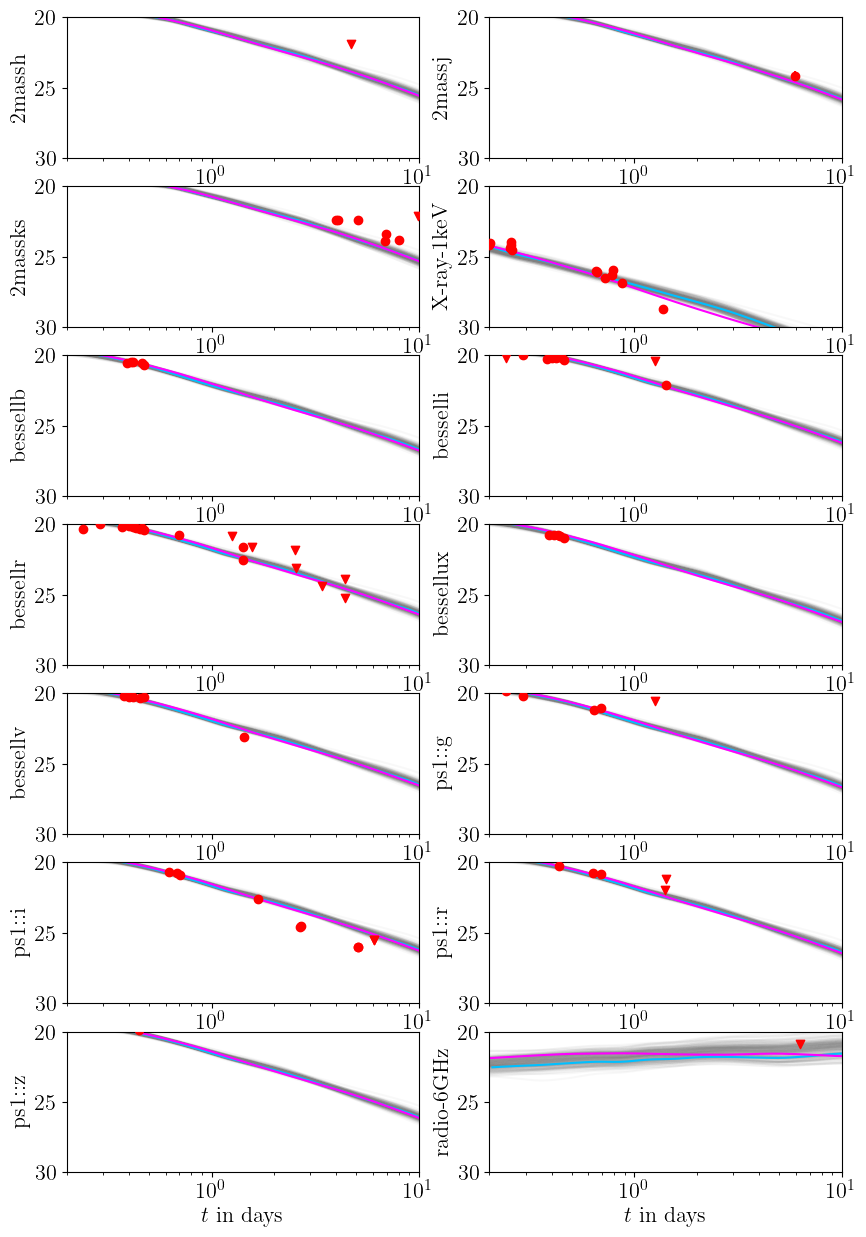

In [10]:
fig, ax = plt.subplots(7, 2, figsize=(10, 15))

for cax, filt in zip(ax.flatten(), data.keys()):
    lc_plotter_afgpy.plot_data(cax, filt, color="red")

    lc_plotter_afgpy.plot_best_fit_lc(cax, filt, color="deepskyblue")
    lc_plotter_pbag.plot_best_fit_lc(cax, filt, color="magenta")
    lc_plotter_afgpy.plot_sample_lc(cax, filt)
    #lc_plotter_afgpy.plot_sys_uncertainty_band(cax, filt, color="deepskyblue")
    #lc_plotter_pbag.plot_sys_uncertainty_band(cax, filt, color="magenta")
    
    cax.invert_yaxis()
    cax.set_xscale("log")
    cax.set_xlim((0.2, 10))
    cax.set_ylim((30, 20))
    cax.set_xlabel("$t$ in days")
    cax.set_ylabel(filt)

fig.show()

In [7]:
lc_plotter_afgpy.get_chisquared(per_dof=True)

(Array(1.011324, dtype=float32),
 {'2massh': Array(nan, dtype=float32),
  '2massj': Array(0.7385827, dtype=float32),
  '2massks': Array(4.7568374, dtype=float32),
  'X-ray-1keV': Array(1.1959907, dtype=float32),
  'bessellb': Array(0.03180013, dtype=float32),
  'besselli': Array(0.16652244, dtype=float32),
  'bessellr': Array(0.5669567, dtype=float32),
  'bessellux': Array(0.15259089, dtype=float32),
  'bessellv': Array(0.29337752, dtype=float32),
  'ps1::g': Array(0.26141313, dtype=float32),
  'ps1::i': Array(2.9179552, dtype=float32),
  'ps1::r': Array(0.2823896, dtype=float32),
  'ps1::z': Array(0.19441496, dtype=float32),
  'radio-6GHz': Array(nan, dtype=float32),
  'uvot::b': Array(0.10170396, dtype=float32),
  'uvot::u': Array(nan, dtype=float32),
  'uvot::uvm2': Array(0.29266804, dtype=float32),
  'uvot::uvw1': Array(0.2415425, dtype=float32),
  'uvot::uvw2': Array(0.03355855, dtype=float32),
  'uvot::v': Array(nan, dtype=float32),
  'uvot::white': Array(1.2161622, dtype=float32

In [8]:
lc_plotter_afgpy.get_chisquared(per_dof=False)

(Array(86.97387, dtype=float32),
 {'2massh': Array(0., dtype=float32),
  '2massj': Array(0.7385827, dtype=float32),
  '2massks': Array(28.541023, dtype=float32),
  'X-ray-1keV': Array(15.547878, dtype=float32),
  'bessellb': Array(0.15900065, dtype=float32),
  'besselli': Array(1.3321795, dtype=float32),
  'bessellr': Array(7.370437, dtype=float32),
  'bessellux': Array(0.7629544, dtype=float32),
  'bessellv': Array(1.7602651, dtype=float32),
  'ps1::g': Array(1.0456525, dtype=float32),
  'ps1::i': Array(23.343641, dtype=float32),
  'ps1::r': Array(0.8471688, dtype=float32),
  'ps1::z': Array(0.19441496, dtype=float32),
  'radio-6GHz': Array(0., dtype=float32),
  'uvot::b': Array(0.30511189, dtype=float32),
  'uvot::u': Array(0., dtype=float32),
  'uvot::uvm2': Array(0.5853361, dtype=float32),
  'uvot::uvw1': Array(0.7246275, dtype=float32),
  'uvot::uvw2': Array(0.0671171, dtype=float32),
  'uvot::v': Array(0., dtype=float32),
  'uvot::white': Array(3.6484866, dtype=float32)})

In [9]:
lc_plotter_pbag.get_chisquared(per_dof=True)

(Array(0.97860587, dtype=float32),
 {'2massh': Array(nan, dtype=float32),
  '2massj': Array(0.73355544, dtype=float32),
  '2massks': Array(4.85773, dtype=float32),
  'X-ray-1keV': Array(0.87669855, dtype=float32),
  'bessellb': Array(0.046788, dtype=float32),
  'besselli': Array(0.27060005, dtype=float32),
  'bessellr': Array(0.62830323, dtype=float32),
  'bessellux': Array(0.2835707, dtype=float32),
  'bessellv': Array(0.30777445, dtype=float32),
  'ps1::g': Array(0.23834813, dtype=float32),
  'ps1::i': Array(2.8781357, dtype=float32),
  'ps1::r': Array(0.09646545, dtype=float32),
  'ps1::z': Array(0.1324868, dtype=float32),
  'radio-6GHz': Array(nan, dtype=float32),
  'uvot::b': Array(0.2510145, dtype=float32),
  'uvot::u': Array(nan, dtype=float32),
  'uvot::uvm2': Array(0.475321, dtype=float32),
  'uvot::uvw1': Array(0.09873454, dtype=float32),
  'uvot::uvw2': Array(0.05072086, dtype=float32),
  'uvot::v': Array(nan, dtype=float32),
  'uvot::white': Array(0.85007244, dtype=float32)

In [10]:
lc_plotter_pbag.get_chisquared(per_dof=False)

(Array(84.1601, dtype=float32),
 {'2massh': Array(0., dtype=float32),
  '2massj': Array(0.73355544, dtype=float32),
  '2massks': Array(29.14638, dtype=float32),
  'X-ray-1keV': Array(11.397081, dtype=float32),
  'bessellb': Array(0.23393999, dtype=float32),
  'besselli': Array(2.1648004, dtype=float32),
  'bessellr': Array(8.167942, dtype=float32),
  'bessellux': Array(1.4178536, dtype=float32),
  'bessellv': Array(1.8466467, dtype=float32),
  'ps1::g': Array(0.9533925, dtype=float32),
  'ps1::i': Array(23.025085, dtype=float32),
  'ps1::r': Array(0.28939635, dtype=float32),
  'ps1::z': Array(0.1324868, dtype=float32),
  'radio-6GHz': Array(0., dtype=float32),
  'uvot::b': Array(0.75304353, dtype=float32),
  'uvot::u': Array(0., dtype=float32),
  'uvot::uvm2': Array(0.950642, dtype=float32),
  'uvot::uvw1': Array(0.2962036, dtype=float32),
  'uvot::uvw2': Array(0.10144171, dtype=float32),
  'uvot::v': Array(0., dtype=float32),
  'uvot::white': Array(2.5502174, dtype=float32)})